# 모두의 딥러닝 20_GAN

https://github.com/gilbutITbook/080228/blob/master/deeplearning/run_project/20_GAN.ipynb

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
#이미지가 저장될 폴더가 없다면 만듭니다.
# import os
# if not os.path.exists("E:\\nmb\\gan_images"):
#     os.makedirs("E:\\nmb\\gan_image")

np.random.seed(3)
# 동일한 세트의 난수를 생성할 수 있다.
tf.random.set_seed(3)
# 모델을 돌릴 때마다 동일한 파라미터를 생성한다.

In [4]:
#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
    # 128 : 임의의 노드 수, 128이 아니어도 충분한 노드를 마련해주면 된다.
    # Input_dim = 100 : 100차원 크기의 랜덤 벡터를 준비해 넣을 것임
    # 7 * 7 : 이미지의 최초 크기 > UpSampling2D 를 거치면서 이미지를 점점 늘려 가는 것이 특징임
    # LeakyReLU() : ReLU()를 사용하게 되면 학습이 불안정해 지는 경우가 많아 ReLU를 변형한 LeakyReLU() 함수를 사용함, 0이하에서도 작은 값을 만들어준다. 
    # LeakyReLU(0.2) : 0보다 작을 경우 0.2를 곱하라는 의미임 
generator.add(BatchNormalization())
    # 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())   
    # 이미지의 가로, 세로 크기를 2배씩 늘려준다.
    # 원본 이미지 크기와 똑같이 되돌리는 데 사용하기 위해서
generator.add(Conv2D(64, kernel_size=5, padding='same'))
    # UpSampling2D() + Conv2D() => Conv2DTranspose()
    # padding = ‘same’ : 생성자가 생성하는 이미지와 실제 이미지의 크기는 동일해야 한다.
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
    # 원본 이미지를 -1와 1 사이로 맞췄기 때문에, 이와 똑같은 값이 나오기 위해서 tanh를 사용함
    # 만약 원본 이미지를 0과 1사이로 맞췄다면 activation='relu'를 사용해도 무방함. 하지만 relu 를 사용했을 때 값들이 손실되는 단점이 있다.
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0

Non-trainable params: 12,672    
* batch_normalization_9 (Batch (None, 6272)              25088     = 6272 * 4     
* normalization_10 (Batc (None, 14, 14, 64)              256       = 64 * 4     
* 각 batch_normalization할 때마다 gamma, beta, running mean and running std 4개를 연산해야 함    
 12,672  = 25088 + 256 / 2



In [6]:
#판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
    # stride : 커널 윈도를 몇 칸씩 이동시킬지를 정하는 옵션
        # -> 가로, 세로 크기가 더 줄어 들어 새로운 특징을 뽑아주는 효과가 생긴다.
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
    # 'sigmoid' : 진짜(1) 혹은 가짜(0) 둘 중에 하나가 되어야 하므로

# compile
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
    # discriminator.trainable = True # > 결과 이상함
    # gan.train_on_batch를 할 때 훈련을 하지 않는다.
    # 판별자의 가중치를 동결함, 컴파일한 판별자 모델이 영향을 받지 않는다.
    # 판별자 스스로는 학습되지 않아야 하기 때문에 학습 기능을 끈다.
    # 판별자는 진짜인지 가짜인지 판별만 해 줄 뿐, 자기 자신이 학습을 해서는 안된다.
    # 전이학습할 때, 전이학습 모델을 훈련시키지 않고 그대로 사용할 거면 False를 쓰는 것과 같은 의미
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_4 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [41]:
#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))                    
    # input : 랜덤한 100개의 벡터를 함수에 넣어 생성자 모델에 넣는다.
dis_output = discriminator(generator(ginput))   
    # 생성자에서 만들어낸 28*28 이미지를 그대로 판별자 모델에 입력 값으로 들어간다.
    # dis_output : 판별자가 판별한 참, 거짓 여부
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [42]:
import numpy as np
true = np.ones((32, 1))   # 1로 라벨링
print(true.shape)     # (32, 1)
print(true[:10])
fake = np.zeros((32, 1))  # 0으로 라벨링
print(fake.shape)     # (32, 1)
print(fake[:10])

(32, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
(32, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [4]:
from datetime import datetime
start = datetime.now()

#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기
  (X_train, _), (_, _) = mnist.load_data()  
  # print(X_train.shape)
    # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  
    # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 
    # 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다. = tanh()
  print(X_train.shape)   # (60000, 28, 28, 1)

    # batch_size : 한 번에 몇 개의 실제 이미지와 몇 개의 가상 이미지를 판별자에 넣을지 결정하는 변수

  true = np.ones((batch_size, 1))   # 실제 이미지는 1로 라벨링 
    # print(true.shape)     # (32, 1)
    # print(true)
  fake = np.zeros((batch_size, 1))  # 가짜 이미지는 0으로 라벨링
    # print(fake.shape)     # (32, 1)
    # print(fake)

  d_loss_list = list()
  g_loss_list = list()


  for i in range(epoch):
        # [1] 실제 데이터를 판별자에 입력하는 부분입니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)    
            # 실제 이미지를 랜덤하게 선택해 불러온다.
            # 0부터 X_train.shape[0] 까지 batch_size만큼 데이터를 가져온다.
            # print(idx.shape)        # (32,) == (batch_size, )
            # print(idx)
        imgs = X_train[idx]
            # idx에 해당하는 실제 이미지를 불러온다.
            # print(imgs.shape)   # (32, 28, 28, 1)
            # print(imgs)

            # 실제 데이터 이미지 확인하기
            # imgs = np.array(imgs[0])
            # imgs = np.reshape(imgs,(28, 28))
            # print(imgs.shape)
            # plt.imshow(imgs,'gray')
            # plt.show()

            
        d_loss_real = discriminator.train_on_batch(imgs, true)
            # x : 랜덤하게 불러온 실제 이미지, y : 실제 이미지 라벨링한 것
            # train_on_batch : fit() 과 유사한 기능을 함
            # fit()과 차이점 : 고정된 batch_size에 신경쓰지 않는다. 
            # x, y 를 받아서 딱 한 번만 학습을 실시해서 모델을 업데이트 한다. 
            # generator는 매번 새로운 image를 전달해야 하기 때문에 새로운 데이터를 학습해야 한다.
            # 현재 전달받은 데이터를 활용해서 가중치를 계산한다.
        
        # [2] 가상 이미지를 판별자에 입력하는 부분입니다.
        noise = np.random.normal(0, 1, (batch_size, 100))   
            # 생성자에 집어넣을 가상 이미지를 만든다. 
            # 평균이 0, 분산이 1인 표준 정규분포, 랜덤한 값을 반환해준다.
            # (batch_size, 100) 행렬로 반환
            # print(noise.shape)  # (32, 100)
            # print(noise)
        gen_imgs = generator.predict(noise)
            # 위에서 만든 가상 이미지를 generator에 넣고 결과값을 저장한다. 
            # print(gen_imgs.shape)     # (32, 28, 28, 1)
            # print(gen_imgs)

            # 실제 데이터 이미지 확인하기
            # gen_imgs = np.array(gen_imgs[0])
            # gen_imgs = np.reshape(gen_imgs,(28, 28))
            # print(gen_imgs.shape)           # (28, 28)
            # plt.imshow(gen_imgs,'gray')
            # plt.show()
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            # generator로 만든 가상 이미지에 가짜 레이블 0을 붙인다.

        #판별자와 생성자의 오차를 계산합니다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
            # 판별자의 오차 : 각 오차의 평균
            # 실제 이미지를 넣은 d_loss_real와 가상 이미지를 입력한 d_loss_fake를 판별자에 넣어 번갈아 가며 진위를 판단한다.
        g_loss = gan.train_on_batch(noise, true)        
            # 생성자의 오차 : g_loss를 구한다.
            # 생성자가 만든 이미지는 무조건 진짜(1)라고 라벨링을 하고 들어간다.
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # loss 값 저장하기
        d_loss_list.append(float(d_loss))
        g_loss_list.append(float(g_loss))

        # pandas dataframe
        d_loss_df = pd.DataFrame(d_loss_list)
        g_loss_df = pd.DataFrame(g_loss_list)

        d_loss_df.columns = ['d_loss']
        g_loss_df.columns = ['g_loss']

        gd_loss_df = pd.concat([d_loss_df, g_loss_df], axis = 1)

        gd_loss_df.to_csv('E:\\nmb\\gan_image\\csv\\loss_gan_1.csv', index = False)

        if i % saving_interval == 0:
            # saving_interval 마다 이미지를 출력한다.
            noise = np.random.normal(0, 1, (25, 100))
              # print(noise.shape)  # (25, 100)
            gen_imgs = generator.predict(noise)
              # print(gen_imgs.shape)   # (25, 28, 28, 1)
            
            gen_imgs = 0.5 * gen_imgs + 0.5
              # Rescale images 0 - 1

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off') # axis를 제거한다.
                      count += 1
            # fig.savefig("E:\\nmb\\gan_image/gan_mnist_%d.png" % i)

epochs = 40001
# gan_train(epochs, 32, 200)

end = datetime.now()
time = end - start
print("작업 시간 : " , time) 

작업 시간 :  0:00:00


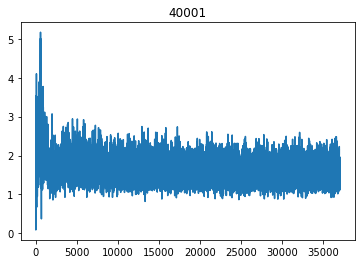

In [5]:
loss_csv = pd.read_csv('E:\\nmb\\gan_image\\csv\\loss_gan_1.csv')
# print(loss_csv)
# print(loss_csv.shape)

# generator loss
plt.plot(loss_csv['g_loss'])

plt.title(epochs)
plt.show()


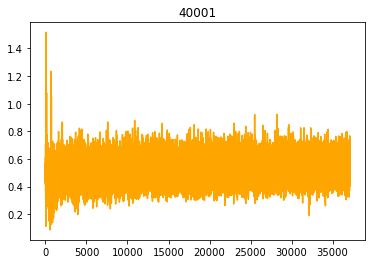

In [6]:
# discriminator loss
plt.plot(loss_csv['d_loss'],color='orange')

plt.title(epochs)
plt.show()